In [1]:
import pandas as pd
import re

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
summary = pd.read_csv("atusdata/atussum_2013.dat")
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [5]:
summary.columns

Index(['tucaseid', 'TUFINLWGT', 'TRYHHCHILD', 'TEAGE', 'TESEX', 'PEEDUCA',
       'PTDTRACE', 'PEHSPNON', 'GTMETSTA', 'TELFS', 
       ...
       't181501', 't181599', 't181601', 't181801', 't189999', 't500101',
       't500103', 't500105', 't500106', 't500107'],
      dtype='object', length=413)

Pertinent columns:

* TUFINLWGT - statistical weight of respondent
* TRYHHCHILD - age of youngest child in household
* TEAGE - age of respondent
* TESEX - sex of respondent
* TELFS - working status of respondent
* TRCHILDNUM - number of children in household

In [6]:
summary.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
adults_crit = summary.TEAGE >= 18
no_children_crit = summary.TRCHILDNUM == 0

In [8]:
adults = summary[adults_crit]
adults.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10953 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 34.6 MB


In [9]:
people_with_no_children = summary[no_children_crit]
people_with_no_children.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6481 entries, 2 to 11381
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 20.5 MB


In [10]:
adults_with_no_children = summary[adults_crit & no_children_crit]
adults_with_no_children.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6481 entries, 2 to 11381
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 20.5 MB


In [11]:
data = adults_with_no_children[['TUFINLWGT', 't120303']]
data = data.rename(columns={"TUFINLWGT": "weight", "t120303": "minutes"})
data.head()

,weight,minutes
2,10377056.507734,60
3,7731257.992805,65
4,4725269.227067,90
5,2372791.046351,270
6,5671341.270490,244


In [12]:
data['weighted_minutes'] = data.weight * data.minutes

In [13]:
data.head()

,weight,minutes,weighted_minutes
2,10377056.507734,60,6.226234e+08
3,7731257.992805,65,5.025318e+08
4,4725269.227067,90,4.252742e+08
5,2372791.046351,270,6.406536e+08
6,5671341.270490,244,1.383807e+09


In [14]:
# Minutes on average spent watching TV (unweighted) - DO NOT USE
data.minutes.sum() / len(data)

211.67427866070051

In [15]:
# Minutes on average spent watching TV (weighted)
data.weighted_minutes.sum() / data.weight.sum()

190.25402840855642

In [16]:
def average_minutes(data, activity_code):
    activity_col = "t{}".format(activity_code)
    data = data[['TUFINLWGT', activity_col]]
    data = data.rename(columns={"TUFINLWGT": "weight", activity_col: "minutes"})
    data['weighted_minutes'] = data.weight * data.minutes
    return data.weighted_minutes.sum() / data.weight.sum()

In [17]:
sleeping = average_minutes(adults_with_no_children, "010101")
sleepless = average_minutes(adults_with_no_children, "010102")
(sleeping + sleepless) / 60 # hours

8.7508537061809992

In [18]:
def activity_columns(data, activity_code):
    """For the activity code given, return all columns that fall under that activity."""
    col_prefix = "t{}".format(activity_code)
    return [column for column in data.columns if re.match(col_prefix, column)]

In [19]:
activity_columns(summary, "0101")

['t010101', 't010102']

In [20]:
def average_minutes2(data, activity_code):
    cols = activity_columns(data, activity_code)
    activity_data = data[cols]
    activity_sums = activity_data.sum(axis=1)
    data = data[['TUFINLWGT']]
    data['minutes'] = activity_sums
    data = data.rename(columns={"TUFINLWGT": "weight"})
    data['weighted_minutes'] = data.weight * data.minutes
    return data.weighted_minutes.sum() / data.weight.sum()

In [21]:
average_minutes2(adults_with_no_children, "0101") / 60

/Users/BekkBlando/Documents/github/atus-analysis/.direnv/python-3.4.3/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8.750853706181001

In [22]:
average_minutes2(adults_with_no_children, "01") / 60

/Users/BekkBlando/Documents/github/atus-analysis/.direnv/python-3.4.3/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9.5541911543273592

In [23]:
# grouping
help(adults_with_no_children.groupby)

Help on method groupby in module pandas.core.generic:

groupby(by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, squeeze=False) method of pandas.core.frame.DataFrame instance
    Group series using mapper (dict or key function, apply given function
    to group, return result as series) or by a series of columns
    
    Parameters
    ----------
    by : mapping function / list of functions, dict, Series, or tuple /
        list of column names.
        Called on each element of the object index to determine the groups.
        If a dict or Series is passed, the Series or dict VALUES will be
        used to determine the groups
    axis : int, default 0
    level : int, level name, or sequence of such, default None
        If the axis is a MultiIndex (hierarchical), group by a particular
        level or levels
    as_index : boolean, default True
        For aggregated output, return object with group labels as the
        index. Only relevant for DataFrame inpu

## Joining files

In [24]:
respondents = pd.read_csv("atusdata/atusresp_2013/atusresp_2013.dat")
activities = pd.read_csv("atusdata/atusact_2013/atusact_2013.dat")

In [25]:
respondents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 175 entries, TUCASEID to TXTONHH
dtypes: float64(1), int64(172), object(2)
memory usage: 15.3+ MB


In [26]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215576 entries, 0 to 215575
Data columns (total 31 columns):
TUCASEID        215576 non-null int64
TUACTIVITY_N    215576 non-null int64
TEWHERE         215576 non-null int64
TRTCCTOT_LN     215576 non-null int64
TRTCC_LN        215576 non-null int64
TRTCOC_LN       215576 non-null int64
TRTEC_LN        215576 non-null int64
TRTHH_LN        215576 non-null int64
TRTNOHH_LN      215576 non-null int64
TRTOHH_LN       215576 non-null int64
TRTONHH_LN      215576 non-null int64
TRTO_LN         215576 non-null int64
TRWBELIG        215576 non-null int64
TUACTDUR        215576 non-null int64
TUACTDUR24      215576 non-null int64
TUCC5           215576 non-null int64
TUCC5B          215576 non-null int64
TUCC7           215576 non-null int64
TUCC8           215576 non-null int64
TUCUMDUR        215576 non-null int64
TUCUMDUR24      215576 non-null int64
TUDURSTOP       215576 non-null int64
TUEC24          215576 non-null int64
TUSTARTTIM     

In [27]:
respondents.head()

,TUCASEID,TULINENO,TUYEAR,TUMONTH,TEABSRSN,TEERN,TEERNH1O,TEERNH2,TEERNHRO,TEERNHRY,...,TXSPEMPNOT,TXSPUHRS,TXTCC,TXTCCTOT,TXTCOC,TXTHH,TXTNOHH,TXTO,TXTOHH,TXTONHH
0,20130101130004,1,2013,1,-1,-1,-1,-1,-1,-1,...,-1,-1,0,0,0,0,0,-1,-1,-1
1,20130101130112,1,2013,1,-1,-1,-1,-1,-1,2,...,0,0,0,0,0,0,-1,0,0,-1
2,20130101130123,1,2013,1,-1,-1,-1,-1,-1,-1,...,0,0,-1,0,0,-1,-1,-1,-1,-1
3,20130101130611,1,2013,1,-1,-1,-1,-1,-1,2,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
4,20130101130616,1,2013,1,-1,-1,-1,-1,-1,2,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1


In [28]:
activities.head()

,TUCASEID,TUACTIVITY_N,TEWHERE,TRTCCTOT_LN,TRTCC_LN,TRTCOC_LN,TRTEC_LN,TRTHH_LN,TRTNOHH_LN,TRTOHH_LN,...,TUDURSTOP,TUEC24,TUSTARTTIM,TUSTOPTIME,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TXWHERE
0,20130101130004,1,-1,0,0,0,-1,0,0,-1,...,2,-1,04:00:00,12:00:00,1,1,1,10101,101,0
1,20130101130004,2,1,5,5,0,-1,5,5,-1,...,1,-1,12:00:00,12:05:00,11,1,1,110101,1101,0
2,20130101130004,3,1,120,120,0,-1,120,120,-1,...,1,-1,12:05:00,14:05:00,12,3,3,120303,1203,0
3,20130101130004,4,1,0,0,0,-1,0,0,-1,...,2,-1,14:05:00,19:00:00,6,3,1,60301,603,0
4,20130101130004,5,1,30,30,0,-1,30,30,-1,...,1,-1,19:00:00,19:30:00,11,1,1,110101,1101,0


In [29]:
merged = pd.merge(respondents, activities, left_on="TUCASEID", right_on="TUCASEID")
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215576 entries, 0 to 215575
Columns: 205 entries, TUCASEID to TXWHERE
dtypes: float64(1), int64(200), object(4)
memory usage: 338.8+ MB


In [30]:
merged[["TUCASEID", "TUACTIVITY_N", "TXTCOC"]].head()

,TUCASEID,TUACTIVITY_N,TXTCOC
0,20130101130004,1,0
1,20130101130004,2,0
2,20130101130004,3,0
3,20130101130004,4,0
4,20130101130004,5,0


In [31]:
telfs = pd.Series({1: "Employed - at work",
                   2: "Employed - absent",
                   3: "Unemployed - laid off",
                   4: "Unemployed - looking",
                   5: "Not in labor force"})

In [32]:
telfs

1       Employed - at work
2        Employed - absent
3    Unemployed - laid off
4     Unemployed - looking
5       Not in labor force
dtype: object

In [33]:
summary.TELFS.map(telfs)

0          Not in labor force
1          Employed - at work
2        Unemployed - looking
3          Employed - at work
4          Employed - at work
5          Not in labor force
6          Not in labor force
7          Employed - at work
8          Employed - at work
9          Employed - at work
10         Employed - at work
11         Employed - at work
12         Employed - at work
13         Employed - at work
14         Not in labor force
15         Not in labor force
16         Employed - at work
17          Employed - absent
18         Employed - at work
19       Unemployed - looking
20       Unemployed - looking
21         Employed - at work
22         Employed - at work
23         Not in labor force
24         Employed - at work
25         Employed - at work
26         Not in labor force
27         Not in labor force
28       Unemployed - looking
29         Employed - at work
                 ...         
11355       Employed - absent
11356      Employed - at work
11357     

In [34]:
working = summary[["t120303","t120308","t120101","t120301"]]
working.columns = ["Watching TV", "Computer For Leasure", "Social for Fun", "Relax and Think"]

KeyError: "['tt120303'] not in index"

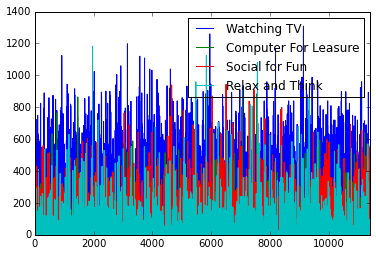

In [45]:
working.plot()
average_minutes(summary, 't120303')